In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn
from plotnine import aes, ggplot
import pathlib
from datetime import datetime
import xlrd
import statsmodels.api as sm

# Import Datasets

Data from the following places will be used. I choose a to use only data from 2021-2023

- CPI (https://stats.oecd.org/index.aspx?DataSetCode=PRICES_CPI#)
- dollar (https://ru.investing.com/currencies/usd-zar-historical-data)
- petrol prices (https://www.energy.gov.za/files/esources/petroleum/petroleum_arch.html)

In [12]:
# get directory path
path = str(pathlib.Path().cwd().parent.parent.resolve())

In [13]:
cpi = pd.read_csv(path + '/data/PRICES_CPI_11062023152547285.csv')
dollar = pd.read_csv(path + '/data/DEXSFUS.csv', delimiter=';')
fuel_2021 = pd.read_csv(path + '/data/Basic-Fuel-Price2021.csv', delimiter=';')
fuel_2022 = pd.read_csv(path + '/data/Basic-Fuel-Price2022.csv', delimiter=';')
fuel_2023 = pd.read_csv(path + '/data/Basic-Fuel-Price2023.csv', delimiter=';')

fuel_2021['year'] = '2021'
fuel_2022['year'] = '2022'
fuel_2023['year'] = '2023'

fuel = pd.concat([fuel_2022[['Petrol 93\r\nUnleaded', 'year', 'RSAc/litre']], fuel_2021[['Petrol 93\r\nUnleaded', 'year', 'RSAc/litre']], fuel_2023[['Petrol 93\r\nUnleaded', 'year', 'RSAc/litre']]])

# EDA
## View CPI

In [14]:
cpi_columns = {'Food and non-Alcoholic beverages' : 'Food', 
               'All items': 'CPI',
               'Alcoholic beverages, tobacco and narcotics': 'Alcohol',
               'Clothing and footwear': 'Clothes',
               'Housing, water, electricity, gas and other fuels': 'Household', 
               'Transport': 'Transport',
               'Recreation and culture': 'Recreation', 
               'Health': 'Health',
               'Furnishings, household equipment and routine household maintenance': 'Furnishings',
               'Communication': 'Communication',
               'Education': 'Education',
               'Restaurants and hotels': 'Restaurants', 
               'Miscellaneous goods and services': 'Other services'}

In [15]:
# Select only where measure in Index
cpi = cpi[cpi['Measure'] == 'National Index']

In [16]:
# get categories
cpi['cpi_cat'] = cpi['Subject'].apply(lambda x: x.split('- ')[-1])
cpi = cpi[cpi['cpi_cat'].isin(cpi_columns)][['Time', 'cpi_cat', 'Value']]

In [17]:
# change month to datetime format
cpi['Date'] = pd.to_datetime(cpi['Time']).dt.strftime('%Y-%m')

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_45949/3347956333.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [18]:
# map categories to shorter names
cpi = cpi.replace(cpi_columns)

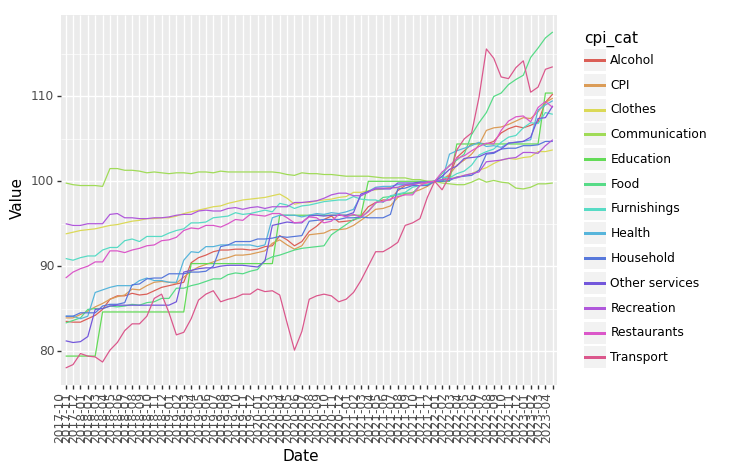

<ggplot: (350102857)>

In [19]:
(ggplot(cpi) + 
pn.geom_line(aes(x='Date', y='Value', color='cpi_cat', group='cpi_cat')) + 
pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)))

In [20]:
cpi = cpi.loc[(cpi['Date'] >= '2021-12-31')]

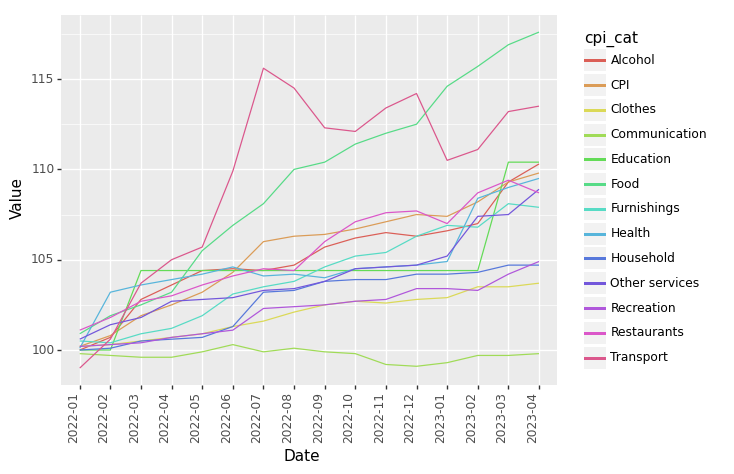

<ggplot: (350518809)>

In [21]:
(ggplot(cpi) + 
pn.geom_line(aes(x='Date', y='Value', color='cpi_cat', group='cpi_cat')) + 
pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)))

# Add Fuel and Dollar

In [22]:
fuel['Time'] = fuel['RSAc/litre'] + '-' + fuel['year']

# # change month to datetime format
fuel['Date'] = pd.to_datetime(fuel['Time']).dt.strftime('%Y-%m')
fuel.columns = ['Petrol', 'year', 'month', 'Time', 'Date']
dollar['Date'] = pd.to_datetime(dollar['DATE'], format='%d.%m.%Y').dt.strftime('%Y-%m')
dollar['Dollar'] = dollar['PRICE'].apply(lambda x: float(x.replace(',', '.')))
dollar.columns = ['Time', 'PRICE', 'Date', 'Dollar']
dollar = dollar[['Date', 'Dollar']].groupby(['Date'])['Dollar'].agg('mean').to_frame().reset_index()

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_45949/3799672639.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [23]:
# correct some incorrect data in fuel prices
fuel['Petrol'] = [float(str(x).replace(' ', '')) for x in fuel['Petrol']]

In [24]:
df_all = pd.merge(cpi, dollar[['Dollar', 'Date']], on='Date', how='left')
df_all = pd.merge(df_all, fuel[['Petrol', 'Date']], on='Date', how='left')

# Add interest rates
https://www.fnb.co.za/rates/LendingRates.html

In [25]:
df_interest = pd.read_csv(path + '/data/fnb_interest.csv', delimiter=';')

In [26]:
df_interest['Date'] = pd.to_datetime(df_interest['Date']).dt.strftime('%Y-%m')

In [27]:
df_all = pd.merge(df_all, df_interest[['Interest', 'Date']], on='Date', how='left')

In [28]:
df_all = df_all.fillna(method='ffill')

In [29]:
for cat in cpi_columns.values():
    df = df_all[df_all['cpi_cat'] == cat]
    print(cat, df[['Value', 'Dollar', 'Interest', 'Petrol']].corr())

Food              Value    Dollar  Interest    Petrol
Value     1.000000  0.929251  0.981181  0.122549
Dollar    0.929251  1.000000  0.928750  0.094242
Interest  0.981181  0.928750  1.000000  0.025276
Petrol    0.122549  0.094242  0.025276  1.000000
CPI              Value    Dollar  Interest    Petrol
Value     1.000000  0.930394  0.960841  0.270311
Dollar    0.930394  1.000000  0.928750  0.094242
Interest  0.960841  0.928750  1.000000  0.025276
Petrol    0.270311  0.094242  0.025276  1.000000
Alcohol              Value    Dollar  Interest    Petrol
Value     1.000000  0.860834  0.921660  0.221809
Dollar    0.860834  1.000000  0.928750  0.094242
Interest  0.921660  0.928750  1.000000  0.025276
Petrol    0.221809  0.094242  0.025276  1.000000
Clothes              Value    Dollar  Interest    Petrol
Value     1.000000  0.951630  0.979904  0.089920
Dollar    0.951630  1.000000  0.928750  0.094242
Interest  0.979904  0.928750  1.000000  0.025276
Petrol    0.089920  0.094242  0.025276  1.00

# Model

# HoltWeiters

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [31]:
df_prophet_pred = []

for cat in cpi_columns.values():
    data = df_all[df_all['cpi_cat']==cat]['Value'].values
    model = ExponentialSmoothing(data, trend='add', initialization_method='legacy-heuristic')
    model_fit = model.fit(optimized=True)
    yhat = model_fit.predict(len(data), len(data))
    df_prophet_pred.append({'Time':'May-2023', 'cpi_cat':cat, 'Value':yhat[0]})

In [32]:
df_may = pd.DataFrame.from_dict(df_prophet_pred)
df_may['Date'] = pd.to_datetime(df_may['Time']).dt.strftime('%Y-%m')

/var/folders/gx/c35dzbl95sg3t62y03g1j6s40000gn/T/ipykernel_45949/2481011324.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [33]:
df_test = df_all[df_all['Date'] == '2023-04']

In [34]:
df = pd.merge(df_test[['cpi_cat', 'Value']], df_may[['cpi_cat', 'Value']].drop_duplicates(keep='first'), left_on='cpi_cat', right_on='cpi_cat')

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
mean_squared_error(df['Value_x'], df['Value_y'])

0.6397164244881579

# Prophet Model

In [37]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [38]:
df_pred = df_test

In [39]:
def train_prophet(df_all, cat, df_pred):
    df = df_all[df_all['cpi_cat'] == cat]
    df = df[['Date', 'Value']]
    df.columns = ['ds', 'y']

    model = Prophet()
    
    model.fit(df)

    df_pred = df_pred[['Date']]
    df_pred.columns = ['ds']

    df_model_pred = model.predict(df_pred)
    df_model_pred['cat'] = cat

    return df_model_pred

In [40]:
df_prophet_pred = []
for cat in cpi_columns.values():
    df_prophet_pred.append(train_prophet(df_all=df_all, cat=cat, df_pred=df_pred))

21:08:27 - cmdstanpy - INFO - Chain [1] start processing
21:08:27 - cmdstanpy - INFO - Chain [1] done processing
21:08:27 - cmdstanpy - INFO - Chain [1] start processing
21:08:27 - cmdstanpy - INFO - Chain [1] done processing
21:08:27 - cmdstanpy - INFO - Chain [1] start processing
21:08:27 - cmdstanpy - INFO - Chain [1] done processing
21:08:27 - cmdstanpy - INFO - Chain [1] start processing
21:08:27 - cmdstanpy - INFO - Chain [1] done processing
21:08:27 - cmdstanpy - INFO - Chain [1] start processing
21:08:27 - cmdstanpy - INFO - Chain [1] done processing
21:08:27 - cmdstanpy - INFO - Chain [1] start processing
21:08:28 - cmdstanpy - INFO - Chain [1] done processing
21:08:28 - cmdstanpy - INFO - Chain [1] start processing
21:08:28 - cmdstanpy - INFO - Chain [1] done processing
21:08:28 - cmdstanpy - INFO - Chain [1] start processing
21:08:28 - cmdstanpy - INFO - Chain [1] done processing
21:08:28 - cmdstanpy - INFO - Chain [1] start processing
21:08:28 - cmdstanpy - INFO - Chain [1]

In [41]:
df_prophet_pred = pd.concat(df_prophet_pred)[['cat', 'trend']].drop_duplicates(keep='first')

In [42]:
df = pd.merge(df_test[['cpi_cat', 'Value']], df_prophet_pred[['cat', 'trend']], left_on='cpi_cat', right_on='cat')

In [43]:
mean_squared_error(df['Value'], df['trend'])

0.21899270640111276

## Baysian VAR

In [60]:
import pymc as pm
import arviz as az

In [47]:
### Define a helper function that will construct our autoregressive step for the marginal contribution of each lagged
### term in each of the respective time series equations
def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
    ars = []
    for j in range(n_eqs):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[j, i] * df.values[n_lags - (i + 1) : -(i + 1)], axis=-1)
                for i in range(n_lags)
            ],
            axis=0,
        )
        ars.append(ar)
    beta = pm.math.stack(ars, axis=-1)

    return beta

In [48]:
def make_model(n_lags, n_eqs, df, priors, mv_norm=True, prior_checks=True):
    coords = {
        "lags": np.arange(n_lags) + 1,
        "equations": df.columns.tolist(),
        "cross_vars": df.columns.tolist(),
        "time": [x for x in df.index[n_lags:]],
    }

    with pm.Model(coords=coords) as model:
        lag_coefs = pm.Normal(
            "lag_coefs",
            mu=priors["lag_coefs"]["mu"],
            sigma=priors["lag_coefs"]["sigma"],
            dims=["equations", "lags", "cross_vars"],
        )
        alpha = pm.Normal(
            "alpha", mu=priors["alpha"]["mu"], sigma=priors["alpha"]["sigma"], dims=("equations",)
        )
        data_obs = pm.Data("data_obs", df.values[n_lags:], dims=["time", "equations"], mutable=True)

        betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df)
        betaX = pm.Deterministic(
            "betaX",
            betaX,
            dims=[
                "time",
            ],
        )
        mean = alpha + betaX

        if mv_norm:
            n = df.shape[1]
            ## Under the hood the LKJ prior will retain the correlation matrix too.
            noise_chol, _, _ = pm.LKJCholeskyCov(
                "noise_chol",
                eta=priors["noise_chol"]["eta"],
                n=n,
                sd_dist=pm.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"]),
            )
            obs = pm.MvNormal(
                "obs", mu=mean, chol=noise_chol, observed=data_obs, dims=["time", "equations"]
            )
        else:
            ## This is an alternative likelihood that can recover sensible estimates of the coefficients
            ## But lacks the multivariate correlation between the timeseries.
            sigma = pm.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
            obs = pm.Normal(
                "obs", mu=mean, sigma=sigma, observed=data_obs, dims=["time", "equations"]
            )

        if prior_checks:
            idata = pm.sample_prior_predictive()
            return model, idata
        else:
            idata = pm.sample_prior_predictive()
            idata.extend(pm.sample(draws=2000, random_seed=130))
            pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)
    return model, idata

In [49]:
n_lags = 2
n_eqs = 4
priors = {
    "lag_coefs": {"mu": 0.3, "sigma": 1},
    "alpha": {"mu": 15, "sigma": 5},
    "noise_chol": {"eta": 1, "sigma": 1},
    "noise": {"sigma": 1},
}


In [50]:
# df_var_pred = []

# for cat in cpi_columns.values():
#     data = df_all[df_all['cpi_cat']==cat][['Value', 'Interest', 'Dollar', 'Petrol']]
#     model, idata = make_model(n_lags, n_eqs, data, priors)


data = df_all[df_all['cpi_cat']=='CPI'][['Value', 'Interest', 'Dollar', 'Petrol']]
model, idata = make_model(n_lags, n_eqs, data, priors)

Sampling: [alpha, lag_coefs, noise_chol, obs]


In [68]:
rng = np.random.default_rng(seed=4)

In [70]:
with model:
    trace = pm.sample(chains=1, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [lag_coefs, alpha, noise_chol]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1377 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


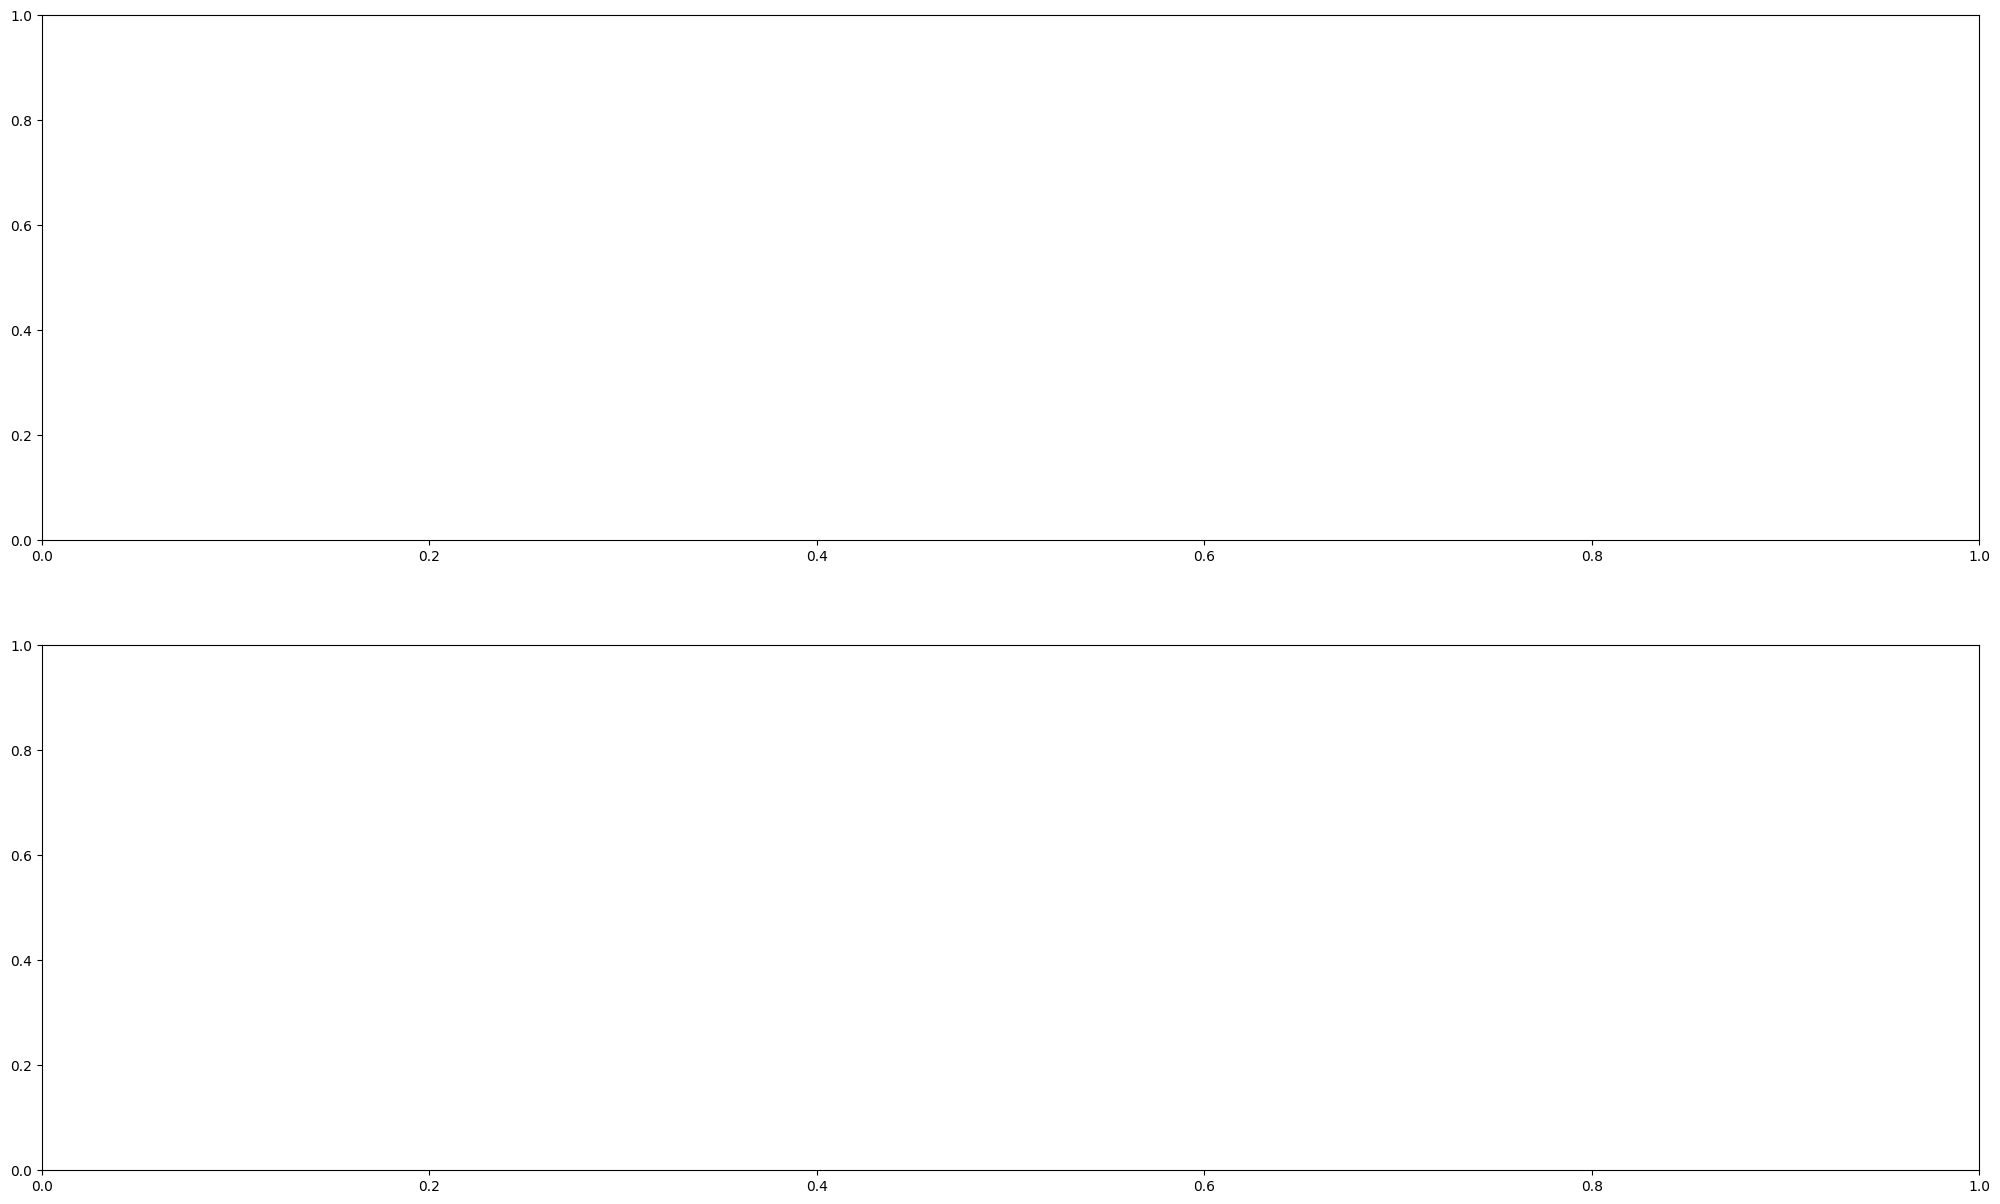

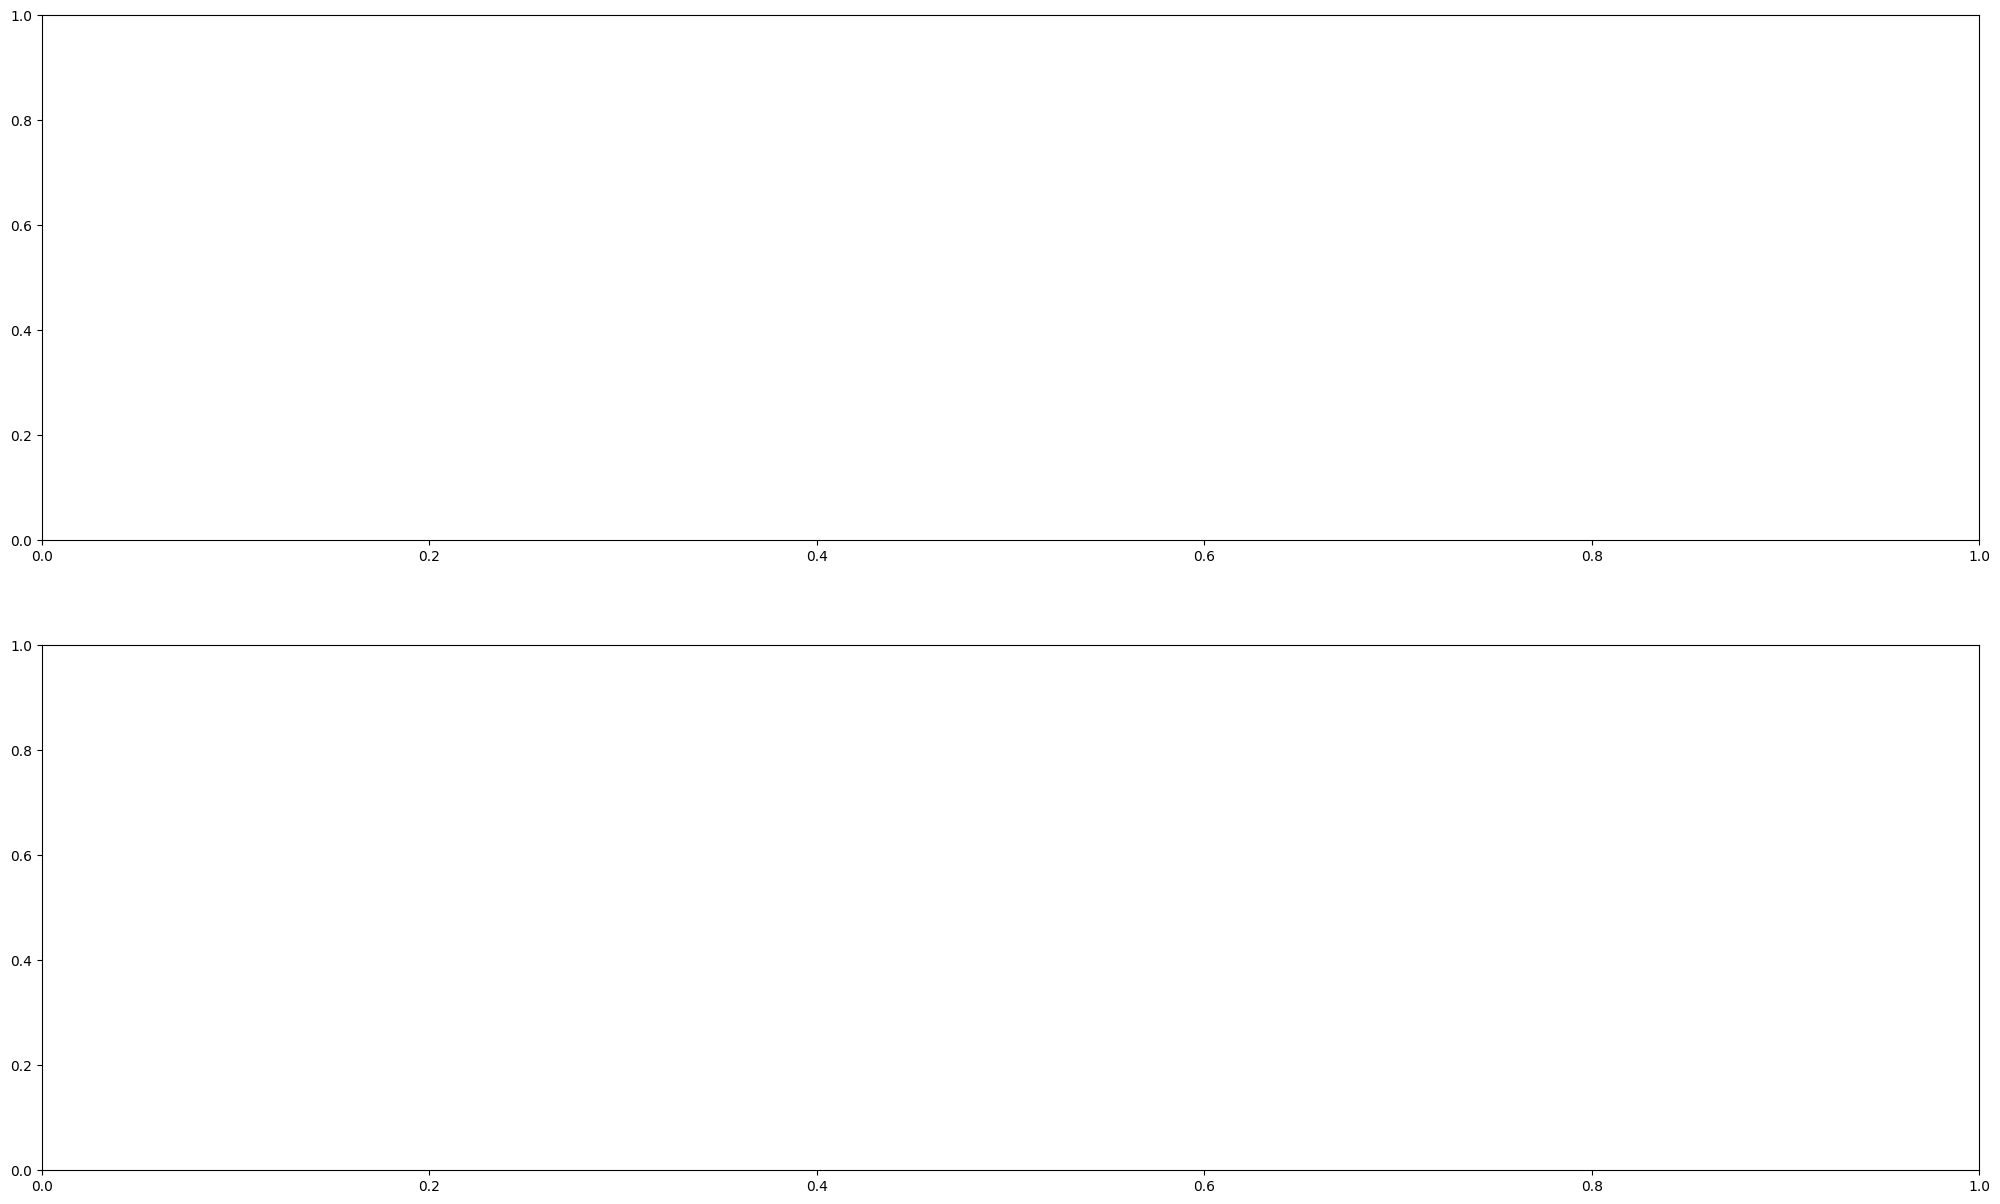

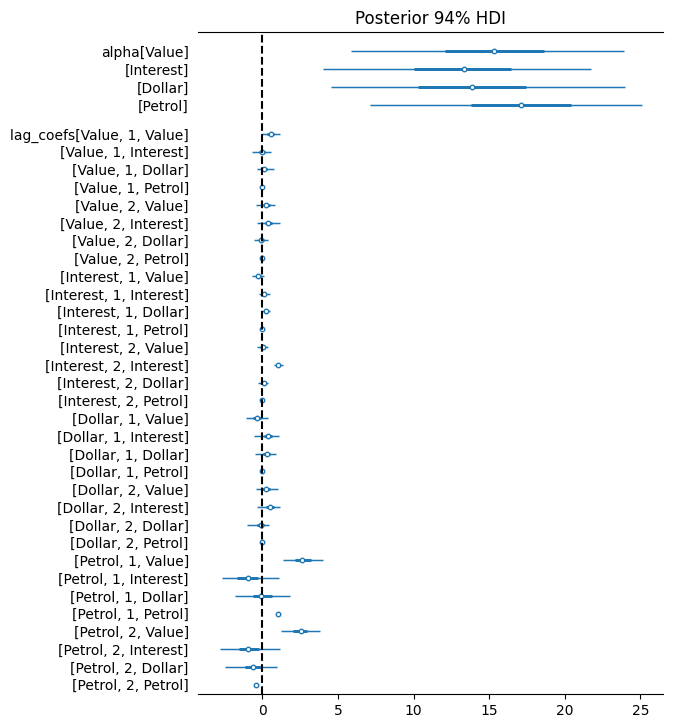

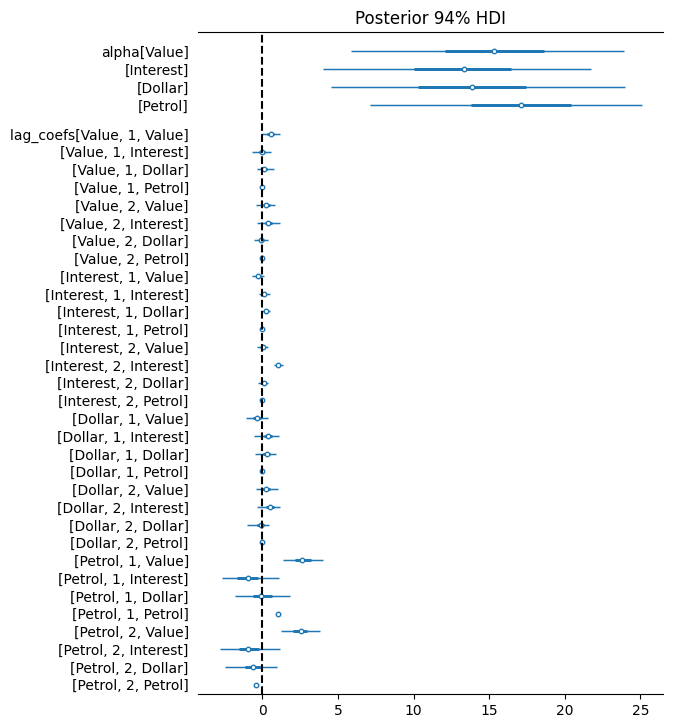

In [76]:
az.plot_forest(trace, var_names=["alpha", "lag_coefs"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI")
plt.show()

In [77]:
# Function that takes a single draw of parameters and forecasts n steps
def _forecast(intercept, lag_coefs, noise, forecast=2):
    len_data = len(data)
    new_draws = np.zeros((data.shape[0]+forecast, data.shape[1]))
    # Fill the new array with the observed data
    new_draws[:len_data] = data[:]
    for i in range(forecast):
        ar_Value = np.sum(lag_coefs[:, 0] * new_draws[len_data+i-lags: len_data+i])
        mean = intercept + np.stack([ar_Value])
        new_draws[len_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    new_draws[:-forecast-1] = np.nan
    return new_draws

# Vectorized forecast function to handle multiple parameter draws
forecast = np.vectorize(
    _forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

In [78]:
# Take a random subset of 100 draws from the posterior
draws = rng.integers(4000, size=100)

post = trace.posterior.stack(sample=("chain", "draw"))
intercept_draws = post["alpha"].values.T[draws]

lag_coefs_draws = post["lag_coefs"].values.T[draws].T
lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 0)

noise_draws = post["noise"].values.T[draws]

intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape

IndexError: index 3660 is out of bounds for axis 0 with size 1000

In [ ]:
# Forecast 10 quarters into the future
ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=10)
ppc_draws = np.swapaxes(ppc_draws, 0, 1)

# Predict June using May's prediction

In [ ]:
df['Date'] = '2023-05'

In [ ]:
df_all = pd.concat((df_all[['cpi_cat', 'Date', 'Value']], df[['cpi_cat', 'Date', 'Value']]))

In [ ]:
df_pred = pd.DataFrame({'Date':['2023-06']})

In [ ]:
df_prophet_pred_june = []
for cat in cpi_columns.values():
    df_prophet_pred_june.append(train_prophet(df_all=df_all, cat=cat, df_pred=df_pred))

In [ ]:
df_prophet_pred_june = pd.concat(df_prophet_pred_june)[['cat', 'trend']].drop_duplicates(keep='first')

In [ ]:
df_prophet_pred_june

# Get Submission

In [ ]:
df_sub = df_prophet_pred_june[['cat', 'trend']]
df_sub.columns = ['ID', 'Value']

In [ ]:
month = 'June'

In [ ]:
pred_map = {'CPI': f'{month}_headline CPI',
'Alcohol': f'{month}_alcoholic beverages and tobacco',
'Clothes': f'{month}_clothing and footwear',
'Communication': f'{month}_communication',
'Education': f'{month}_education',
'Food': f'{month}_food and non-alcoholic beverages',
'Health': f'{month}_health',
'Furnishings': f'{month}_household contents and services',
'Household': f'{month}_housing and utilities',
'Other services': f'{month}_miscellaneous goods and services',
'Recreation': f'{month}_recreation and culture',
'Restaurants': f'{month}_restaurants and hotels',
'Transport': f'{month}_transport'}

In [ ]:
df_sub = df_sub.replace(pred_map)

In [ ]:
df_sub.to_csv(path + '/submissions/v10_prophet.csv', index=False)